In [232]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [233]:
data=pd.read_csv('Train_Data.csv')

In [234]:
df = pd.DataFrame(data)
df.head()

,SEQN,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,73564.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,Adult
1,73568.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85,Adult
2,73576.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14,Adult
3,73577.0,1.0,2.0,28.9,104.0,NaN,84.0,16.15,Adult
4,73580.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92,Adult


In [235]:
df.columns

Index(['SEQN', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT',
       'LBXIN', 'age_group'],
      dtype='object')

In [236]:
# SEQN: identifier
# RIAGENDR: gender 1=male, 2=female
# PAQ605: physical activity
# BMXBMI: bmi
# LBXGLU: glucose level
# DIQ010: diabetes response
# LBXGLT: glucose tolerance
# LBXIN: insulin level

In [237]:
df['age_group'].value_counts(normalize=True)

age_group
Adult     0.839139
Senior    0.160861
Name: proportion, dtype: float64

In [238]:
df.isnull().sum()

SEQN         12
RIAGENDR     18
PAQ605       13
BMXBMI       18
LBXGLU       13
DIQ010       18
LBXGLT       11
LBXIN         9
age_group    14
dtype: int64

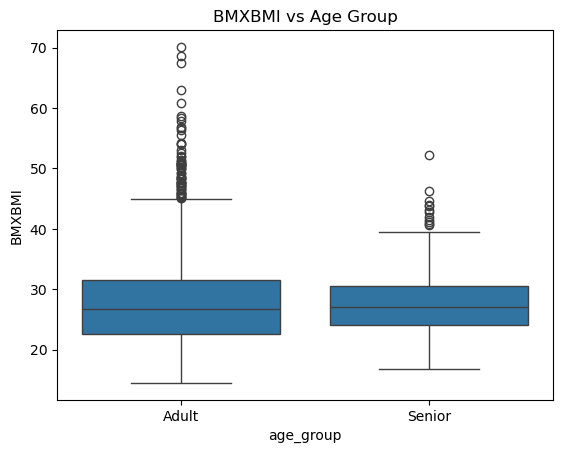

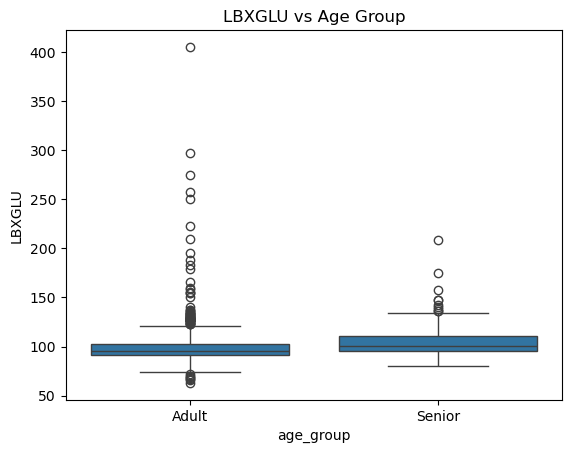

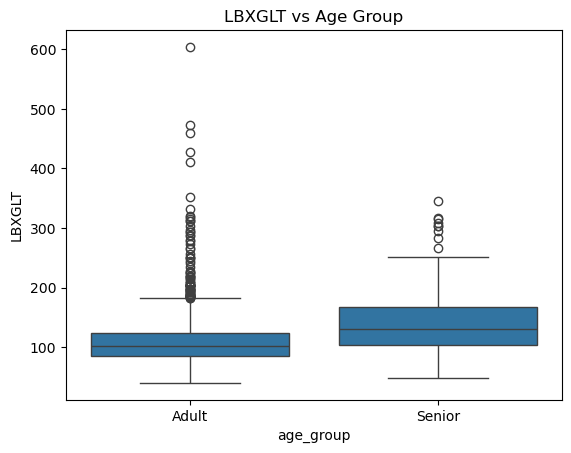

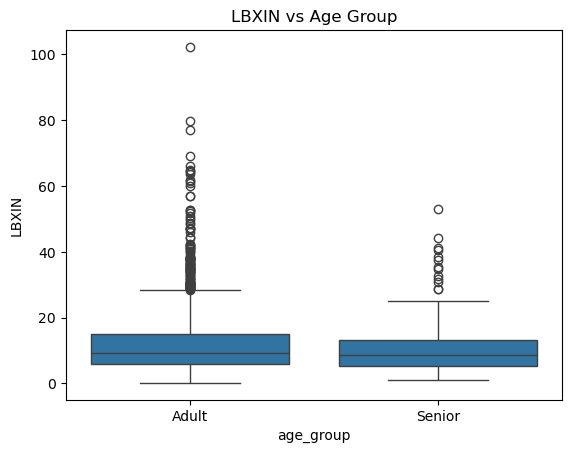

In [239]:
for col in ['BMXBMI','LBXGLU','LBXGLT','LBXIN']:
    sns.boxplot(x='age_group', y=col, data=df)
    plt.title(f'{col} vs Age Group')
    plt.show()

## Data Processing

In [240]:
df = df.drop(columns=['SEQN'])

In [241]:
df['PAQ605'] = df['PAQ605'].fillna(0)
df['DIQ010'] = df['DIQ010'].fillna(0)

In [242]:
num_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']

for col in num_cols:
    if df[col].dtype == 'float_64':
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

In [243]:
df['RIAGENDR'] = df['RIAGENDR'].fillna(df['RIAGENDR'].mode()[0])

In [244]:
df = pd.get_dummies(df, columns=['RIAGENDR', 'PAQ605', 'DIQ010'], drop_first=False)

In [245]:
df = df[df['age_group'].notna()]

In [246]:
df['age_group'] = df['age_group'].map({'Adult': 0, 'Senior': 1}).astype(int)

In [247]:
import numpy as np

df['GLU_DIV_INS'] = df['LBXGLU'] / (df['LBXIN'] + 1e-5)
df['log_GLU'] = np.log1p(df['LBXGLU'])
df['log_INS'] = np.log1p(df['LBXIN'])

## Train Test Split

In [248]:
X = df.drop(columns=['age_group'])
y = df['age_group']

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [249]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None # for auc-roc

    print("f1 score:", f1_score(y_val, y_pred))
    print("\nconfusion matrix:\n", confusion_matrix(y_val, y_pred))
    print("\nclassification report:\n", classification_report(y_val, y_pred))
    if y_prob is not None:
        print("AUC score:", roc_auc_score(y_val, y_prob))

## Training the Model

In [250]:
'''
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves': [15, 31],
    'max_depth': [-1, 5],
    'learning_rate': [0.01, 0.05],
    'min_child_samples': [20, 30],
    'n_estimators': [100, 200],
    'reg_alpha': [0.0, 0.1, 1.0],
    'reg_lambda': [0.0, 0.1, 1.0]
}

lgbm = LGBMClassifier(is_unbalance=True, random_state=42, n_jobs=-1)
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)
grid_lgbm.fit(X_train, y_train)
best_lgbm = grid_lgbm.best_estimator_
evaluate_model(best_lgbm, X_val, y_val)
'''

"\nfrom lightgbm import LGBMClassifier\nfrom sklearn.model_selection import GridSearchCV\n\nparam_grid = {\n    'num_leaves': [15, 31],\n    'max_depth': [-1, 5],\n    'learning_rate': [0.01, 0.05],\n    'min_child_samples': [20, 30],\n    'n_estimators': [100, 200],\n    'reg_alpha': [0.0, 0.1, 1.0],\n    'reg_lambda': [0.0, 0.1, 1.0]\n}\n\nlgbm = LGBMClassifier(is_unbalance=True, random_state=42, n_jobs=-1)\ngrid_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)\ngrid_lgbm.fit(X_train, y_train)\nbest_lgbm = grid_lgbm.best_estimator_\nevaluate_model(best_lgbm, X_val, y_val)\n"

In [251]:
# --- Step 3: Train LightGBM with GridSearchCV ---
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'num_leaves': [15, 31],
    'max_depth': [-1, 5],
    'learning_rate': [0.01, 0.05],
    'min_child_samples': [20, 30],
    'n_estimators': [100, 200],
    'reg_alpha': [0.0, 0.1, 1.0],
    'reg_lambda': [0.0, 0.1, 1.0]
}

# Initial LGBMClassifier
lgbm = LGBMClassifier(is_unbalance=True, random_state=42, n_jobs=-1)

# GridSearchCV
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)
grid_lgbm.fit(X_train, y_train)

# Best model
best_lgbm = grid_lgbm.best_estimator_
evaluate_model(best_lgbm, X_val, y_val)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[LightGBM] [Info] Number of positive: 251, number of negative: 1310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1326
[LightGBM] [Info] Number of data points in the train set: 1561, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160794 -> initscore=-1.652329
[LightGBM] [Info] Start training from score -1.652329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [252]:
# --- Step 4: Get Top N Features from best_lgbm ---
importances = pd.Series(best_lgbm.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False)
N = 12  # Changeable depending on performance
selected_features = top_features.head(N).index.tolist()

X_train_top = X_train[selected_features]
X_val_top = X_val[selected_features]

In [253]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']  # Very important for class imbalance
}

# RandomForest setup
rf = RandomForestClassifier(random_state=42)

# Grid search
grid_rf = GridSearchCV(rf, param_grid_rf, scoring='f1', cv=5, n_jobs=-1, verbose=1)

# Fit on top features (no SMOTE!)
grid_rf.fit(X_train_top, y_train)

# Get best model
best_rf = grid_rf.best_estimator_
evaluate_model(best_rf, X_val_top, y_val)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
f1 score: 0.32926829268292684

confusion matrix:
 [[254  74]
 [ 36  27]]

classification report:
               precision    recall  f1-score   support

           0       0.88      0.77      0.82       328
           1       0.27      0.43      0.33        63

    accuracy                           0.72       391
   macro avg       0.57      0.60      0.58       391
weighted avg       0.78      0.72      0.74       391

AUC score: 0.6950251645373597


In [224]:
# --- Step 5: Retrain best_lgbm on top N features ---
lgbm_top = LGBMClassifier(
    is_unbalance=True,
    random_state=42,
    **grid_lgbm.best_params_,
    n_jobs=-1
)

lgbm_top.fit(X_train, y_train)
evaluate_model(lgbm_top, X_val_top, y_val)

[LightGBM] [Info] Number of positive: 1310, number of negative: 1310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 2620, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

## Preparing test data

In [254]:
test_data = pd.read_csv('Test_Data.csv')

In [255]:
test_df = pd.DataFrame(test_data)
test_df.head()

,SEQN,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,77017.0,1.0,1.0,32.2,96.0,2.0,135.0,15.11
1,75580.0,2.0,2.0,26.3,100.0,2.0,141.0,15.26
2,73820.0,1.0,2.0,28.6,107.0,2.0,136.0,8.82
3,80489.0,2.0,1.0,22.1,93.0,2.0,111.0,12.13
4,82047.0,1.0,1.0,24.7,91.0,2.0,105.0,3.12


In [256]:
test_df = test_df.drop(columns=['SEQN'])
test_df['PAQ605'] = test_df['PAQ605'].fillna(0)
test_df['DIQ010'] = test_df['DIQ010'].fillna(0)

num_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']

num_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']

for col in num_cols:
    if test_df[col].dtype == 'float_64':
        test_df[col] = test_df[col].fillna(test_df[col].median())
    else:
        test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

test_df['RIAGENDR'] = test_df['RIAGENDR'].fillna(test_df['RIAGENDR'].mode()[0])
test_df = pd.get_dummies(test_df, columns=['RIAGENDR', 'PAQ605', 'DIQ010'], drop_first=False)

test_df['GLU_DIV_INS'] = test_df['LBXGLU'] / (test_df['LBXIN'] + 1e-5)
test_df['log_GLU'] = np.log1p(test_df['LBXGLU'])
test_df['log_INS'] = np.log1p(test_df['LBXIN'])

df, test_df = df.align(test_df, join='left', axis=1, fill_value=0)

In [257]:
test_top = test_df[selected_features]

In [258]:
## missing_cols = set(X.columns) - set(test_df.columns)

## for col in missing_cols:
    ## test_df[col] = 0
## test_df = test_df[X.columns]

In [259]:
test_preds = best_rf.predict(test_top)

In [260]:
submission = pd.DataFrame({'age_group':test_preds})
submission.to_csv('new_sub8.csv', index=False)